In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3b_NE_305stop.root")
#file = ROOT.TFile.Open("run3b_33start.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

loss_file = ROOT.TFile.Open("LostMuonsSpectra.root")
direc = loss_file.Get("Run3b")
hlm = ROOT.TH1F()
hlm = direc.Get("triple_losses_spectra_integral")

loss_file_2 = ROOT.TFile.Open("reconEmuonloss.root")
#direc = loss_file.Get("Run3a")
hlm_2 = ROOT.TH1D()
hlm_2 = loss_file_2.Get("lambda3B")

In [3]:
hlm.Scale(1.0/hlm.GetBinContent(hlm.GetNbinsX()))
hlm_2.Scale(1.0/hlm_2.GetBinContent(hlm_2.GetNbinsX()))

In [4]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [5]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)
x_mloss=np.empty(fit_range)
y_mloss=np.empty(fit_range)
x_mloss_2=np.empty(fit_range)
y_mloss_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
    x_mloss[ibin]=hlm.GetBinCenter(ibin+hlm.FindBin(fit_start))
    y_mloss[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start))
    x_mloss_2[ibin]=hlm_2.GetBinCenter(ibin+hlm_2.FindBin(fit_start))
    y_mloss_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [6]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

8.270095283876686e-09


In [7]:
y_mlossf=np.empty(fit_range)
y_mlossb=np.empty(fit_range)

y_mlossf_2=np.empty(fit_range)
y_mlossb_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_mlossf[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)+nbinshift)
    y_mlossb[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)-nbinshift) 
    y_mlossf_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)+nbinshift)
    y_mlossb_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)-nbinshift)

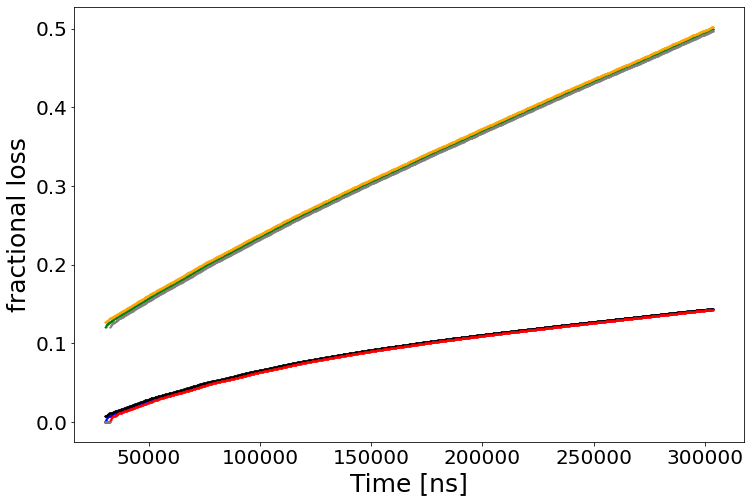

In [8]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.scatter(x_mloss_2, y_mloss_2, s=0.9, color='red', label='Data')
plt.scatter(x_mloss, y_mloss, s=0.9, color='blue', label='Data')
plt.scatter(x_mloss, y_mlossf, s=0.9, color='black', label='Data')
plt.scatter(x_mloss, y_mlossb, s=0.9, color='red', label='Data')
plt.scatter(x_mloss_2, y_mloss_2, s=0.9, color='green', label='Data')
plt.scatter(x_mloss_2, y_mlossf_2, s=0.9, color='orange', label='Data')
plt.scatter(x_mloss_2, y_mlossb_2, s=0.9, color='gray', label='Data')
#plt.plot(x_val, fit, linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('fractional loss',fontsize=25)
#plt.ylim([0.08,0.17])
#plt.xlim([25000,40000])
plt.show()

In [9]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0)-> np.double:
             #asym_vw= 0.0,
             #tau_vw = 0.0,
             #omega_vw = 0.0,
             #phi_vw = 0.0,
             #asym_vbo= 0.0,
             #tau_vbo = 0.0,
             #omega_vbo = 0.0,
             #phi_vbo = 0.0,
             #asym_2cbo= 0.0,
             #phi_2cbo = 0.0,
             #tau_rlx = 0.0,
             #A_cbot = 0.0,
             #tau_cbot = 0.0)-> np.double:
    
  
    
    #omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    #omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    #omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    #Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    #Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    #Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    #Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    #Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    #Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    #N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    #N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    #N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    #Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    #Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    #Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    #Ncbo=Ncbo+N2cbo
    #Ncbof=Ncbof+N2cbof
    #Ncbob=Ncbob+N2cbob
    

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    #return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [10]:
def fit_func_RW(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0)-> np.double:
             #asym_vw= 0.0,
             #tau_vw = 0.0,
             #omega_vw = 0.0,
             #phi_vw = 0.0,
             #asym_vbo= 0.0,
             #tau_vbo = 0.0,
             #omega_vbo = 0.0,
             #phi_vbo = 0.0,
             #asym_2cbo= 0.0,
             #phi_2cbo = 0.0,
             #tau_rlx = 0.0,
             #A_cbot = 0.0,
             #tau_cbot = 0.0,
             #A_cbovw = 0.0,
             #phi_cbovw = 0.0)-> np.double:
    
   
    
    A_lm=-0.00959
    
    #omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    #omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    #omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    #Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    #Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    #Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    #Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    #Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    #Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    #N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    #N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    #N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    #Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    #Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    #Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    #Ncbo=Ncbo+N2cbo
    #Ncbof=Ncbof+N2cbof
    #Ncbob=Ncbob+N2cbob
    
    Nloss = (1 - A_lm * y_mloss)
    Nlossf = (1 - A_lm * y_mlossf) 
    Nlossb = (1 - A_lm * y_mlossb)

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    return (2*f*Ncbo*Nloss - ff*Ncbof*Nlossf - fb*Ncbob*Nlossb)/(2*f*Ncbo*Nloss + ff*Ncbof*Nlossf + fb*Ncbob*Nlossb)
    #return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)

In [11]:
def fit_func_RE(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0)-> np.double:
             #asym_vw= 0.0,
             #tau_vw = 0.0,
             #omega_vw = 0.0,
             #phi_vw = 0.0,
             #asym_vbo= 0.0,
             #tau_vbo = 0.0,
             #omega_vbo = 0.0,
             #phi_vbo = 0.0,
             #asym_2cbo= 0.0,
             #phi_2cbo = 0.0,
             #tau_rlx = 0.0,
             #A_cbot = 0.0,
             #tau_cbot = 0.0)-> np.double:
    
    A_lm=-0.00167
    
    #omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    #omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    #omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    #Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    #Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    #Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    #Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    #Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    #Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    #N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    #N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    #N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    #Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    #Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    #Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    #Ncbo=Ncbo+N2cbo
    #Ncbof=Ncbof+N2cbof
    #Ncbob=Ncbob+N2cbob
    
    Nloss = (1 - A_lm * y_mloss_2)
    Nlossf = (1 - A_lm * y_mlossf_2) 
    Nlossb = (1 - A_lm * y_mlossb_2)

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    #return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)
    return (2*f*Ncbo*Nloss - ff*Ncbof*Nlossf - fb*Ncbob*Nlossb)/(2*f*Ncbo*Nloss + ff*Ncbof*Nlossf + fb*Ncbob*Nlossb)

In [12]:
p_init=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        238000,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5]

In [13]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [14]:
p_init=pars2

In [15]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [16]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [17]:
for ipar in range(0,11):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22820193922136378        +-   1.3726640343256695e-05   

-34.111335858819174        +-   0.7622845752802963   

3.996684083405188        +-   0.00011613444586104276   

-0.0011214747286327808        +-   4.1313176914759856e-05   

213099.634148745        +-   21061.827083788234   

0.002331194250228404        +-   4.660095572518674e-07   

2.5795006454496856        +-   0.0371511660239969   

-0.0003658822595390833        +-   0.00012387577765154463   

2.224912903374659        +-   0.33565556614802056   

-7.650802182720093e-05        +-   0.00012496185806685995   

-1.55921076743925        +-   1.632084563852177   



Text(0, 0.5, 'FFT Mag [arb. units]')

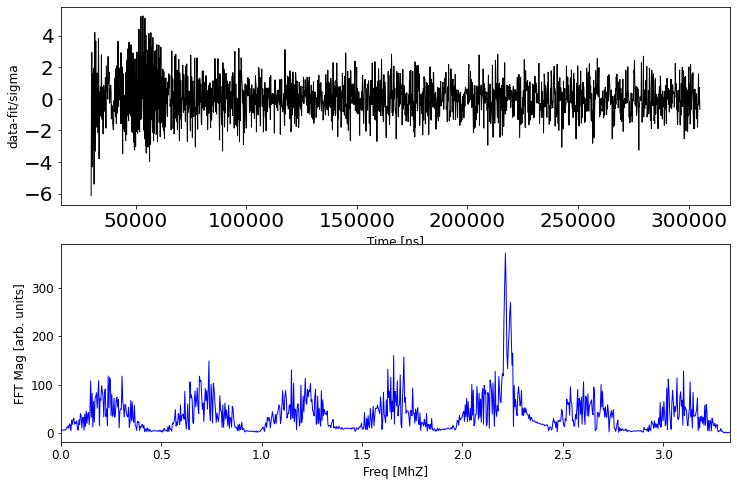

In [18]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

fou=abs(np.fft.fft(res))

#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)



plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [19]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))
ndf=fit_range-len(pars_final)
red_chi2=chi2/ndf
red_chi2

1.5473925690455643

In [20]:
p_init_RW=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        238000,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5]

In [21]:
pars2_RW, cov2_RW = opt.curve_fit(f=fit_func_RW, xdata=x_val, ydata=y_val, p0=p_init_RW, sigma=y_err)

In [22]:
p_init_RW=pars2_RW

In [23]:
pars_final_RW, cov_final_RW = opt.curve_fit(f=fit_func_RW, xdata=x_val, ydata=y_val, p0=p_init_RW, sigma=y_cov)

In [24]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_RW = np.sqrt(np.diag(cov_final_RW))

In [25]:
for ipar in range(0,11):
    print(pars_final_RW[ipar],"       +-  ",stdevs_RW[ipar],"  \n")

0.2282028990482358        +-   1.3716427501035562e-05   

-34.074903563544346        +-   0.7615946860111361   

3.996691095833565        +-   0.00011605003205313284   

-0.0011216299219832342        +-   4.130001946235039e-05   

212862.4268402922        +-   21011.043289232726   

0.002331226031929115        +-   4.659229092569975e-07   

2.5833220289967787        +-   0.037134491573235125   

-0.0003755482068165708        +-   0.00012385727888820734   

2.2186280764159587        +-   0.3269593702603174   

8.33927736582569e-05        +-   0.00012528773626388007   

7.720098801713773        +-   1.4932154268663678   



Text(0, 0.5, 'FFT Mag [arb. units]')

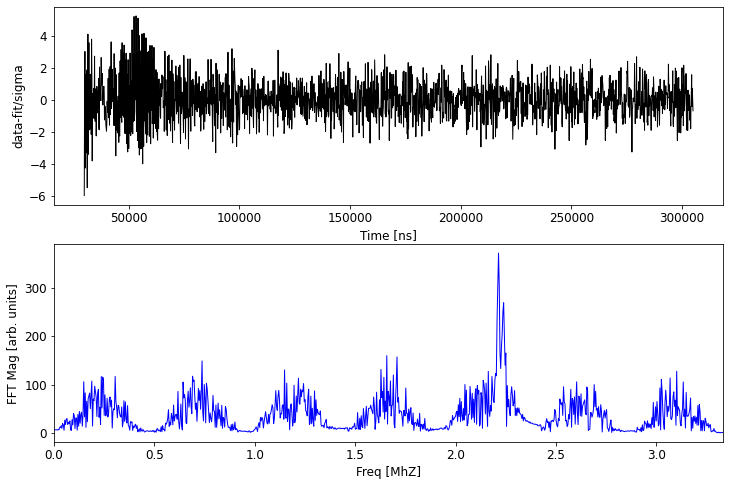

In [26]:
# Calculate the residuals
res_RW = (y_val - fit_func_RW(x_val, *pars_final_RW))/y_err

fou_RW=abs(np.fft.fft(res_RW))

#xfft=np.empty(fit_range)
xfft_RW= np.linspace(0,6.667,num=fit_range)



plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res_RW, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft_RW, fou_RW, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [27]:
chi2_RW=np.dot((np.transpose(y_val-fit_func_RW(x_val, *pars_final_RW))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_RW(x_val, *pars_final_RW)))))
ndf_RW=fit_range-len(pars_final_RW)
red_chi2_RW=chi2_RW/ndf
red_chi2_RW

1.5451459449130123

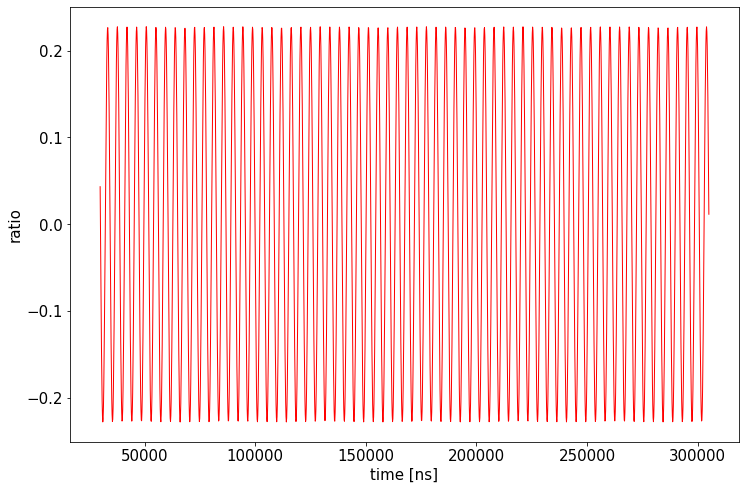

In [28]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func_RW(x_val, *pars_final_RW), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

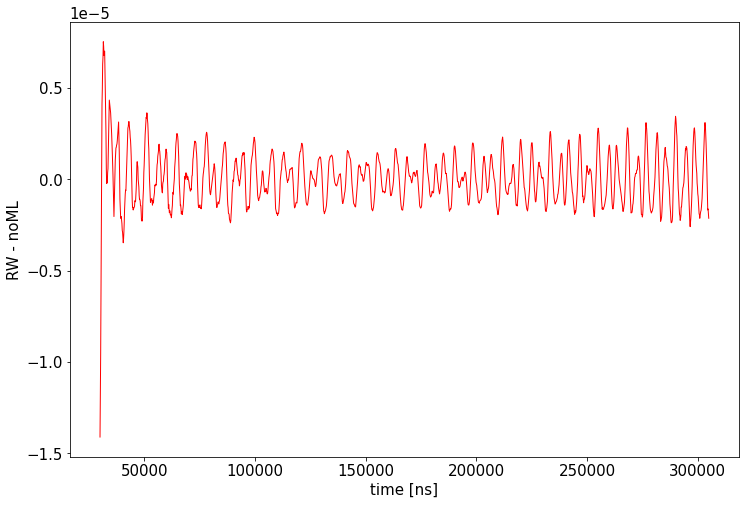

In [29]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, (fit_func_RW(x_val, *pars_final_RW))-(fit_func(x_val, *pars_final)), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('RW - noML',fontsize=15)
#plt.ylim(0.99998,1.00002)
#plt.xlim(29000,40000)
plt.show()

In [30]:
p_init_RE=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        238000,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5]

In [31]:
pars2_RE, cov2_RE = opt.curve_fit(f=fit_func_RE, xdata=x_val, ydata=y_val, p0=p_init_RE, sigma=y_err)

In [32]:
p_init_RE=pars2_RE

In [33]:
pars_final_RE, cov_final_RE = opt.curve_fit(f=fit_func_RE, xdata=x_val, ydata=y_val, p0=p_init_RE, sigma=y_cov)

In [34]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_RE = np.sqrt(np.diag(cov_final_RE))

In [35]:
for ipar in range(0,11):
    print(pars_final_RE[ipar],"       +-  ",stdevs_RE[ipar],"  \n")

0.22820778215000986        +-   1.37228739600164e-05   

-34.150636320092424        +-   0.7620454114549255   

3.996675249386237        +-   0.0001161017747524259   

-0.0011287402713530152        +-   4.1521858618230495e-05   

210404.7483965717        +-   20566.11654794914   

0.0023311229140931043        +-   4.6661484225044944e-07   

2.572048410552043        +-   0.03708458713136828   

-0.00039454799031990716        +-   0.00012437766227900855   

2.129042615685469        +-   0.31274352807281386   

8.518497998636447e-05        +-   0.00012656349769749582   

-11.922546136636926        +-   1.458824356842755   



Text(0, 0.5, 'FFT Mag [arb. units]')

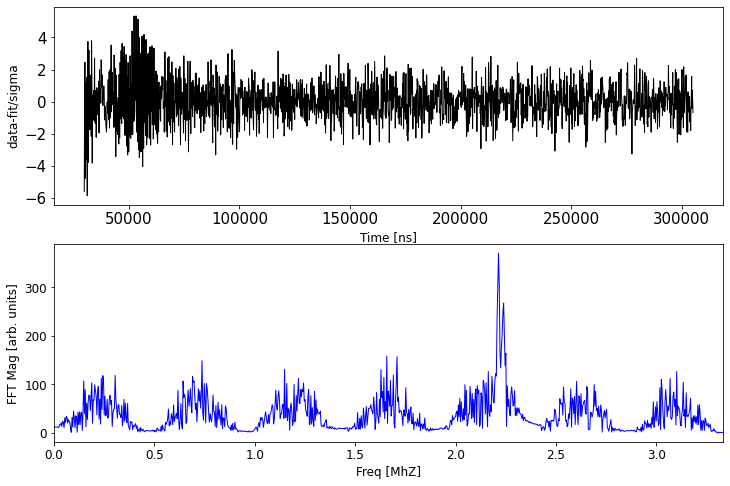

In [36]:
# Calculate the residuals
res_RE = (y_val - fit_func_RE(x_val, *pars_final_RE))/y_err

fou_RE=abs(np.fft.fft(res_RE))

#xfft=np.empty(fit_range)
xfft_RE= np.linspace(0,6.667,num=fit_range)



plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res_RE, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft_RE, fou_RE, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [37]:
chi2_RE=np.dot((np.transpose(y_val-fit_func_RE(x_val, *pars_final_RE))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_RE(x_val, *pars_final_RE)))))
ndf_RE=fit_range-len(pars_final_RE)
red_chi2_RE=chi2_RE/ndf
red_chi2_RE

1.5465361255282084

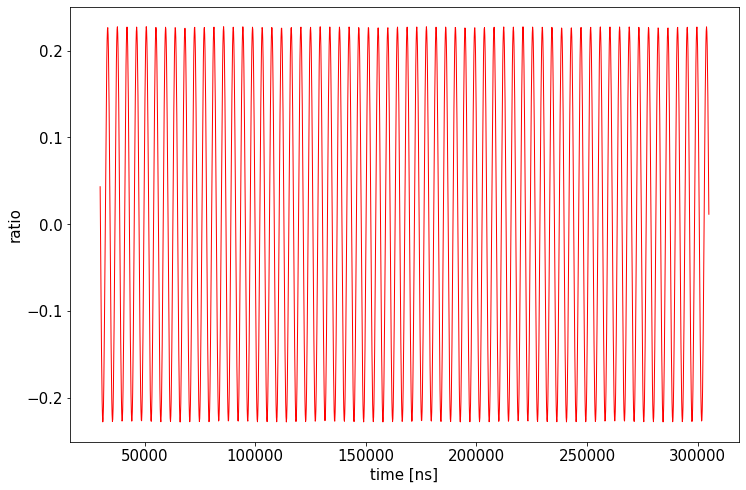

In [38]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func_RE(x_val, *pars_final_RE), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

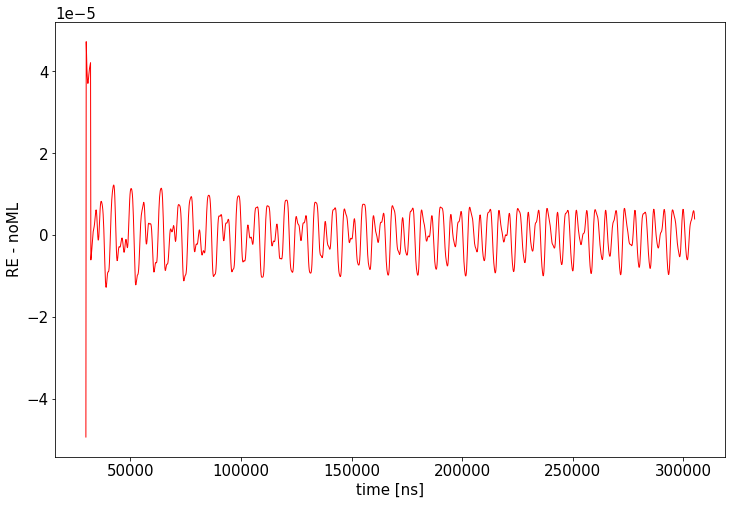

In [39]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, (fit_func_RE(x_val, *pars_final_RE))-(fit_func(x_val, *pars_final)), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('RE - noML',fontsize=15)
#plt.ylim(0.99998,1.00002)
#plt.xlim(29000,40000)
plt.show()

In [41]:
pars_final_RE[1]-pars_final[1]

-0.03930046127324971

In [42]:
pars_final_RW[1]-pars_final[1]

0.036432295274828164